In [6]:
from google.colab import drive
import os

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
base_dir = '/content/drive/MyDrive/Mountains vs Beach'

! ls "/content/drive/MyDrive/Mountains vs Beach"

testing  training  validation


In [8]:
testing_dir = os.path.join(base_dir, 'testing')
training_dir = os.path.join(base_dir, 'training')
validation_dir = os.path.join(base_dir, 'validation')

In [9]:
beaches_dir = os.path.join(testing_dir, 'beaches/')
mountains_dir = os.path.join(testing_dir, 'mountains/')

print ('Jumlah Data Train Tiap Kelas')
print ('Total gambar pantai:', len(os.listdir(beaches_dir)))
print ('Total gambar pegunungan:', len(os.listdir(mountains_dir)))

Jumlah Data Train Tiap Kelas
Total gambar pantai: 50
Total gambar pegunungan: 50


In [10]:
train_beaches = os.path.join(training_dir, 'beaches/')
train_mountains = os.path.join(training_dir, 'mountains/')

validation_beaches = os.path.join(validation_dir, 'beaches/')
validation_mountains = os.path.join(validation_dir, 'mountains/')

In [11]:
import random
from shutil import copyfile

def train_val_split(source, train, val, train_ratio):
  total_size = len(os.listdir(source))
  train_size = int(total_size * train_ratio)
  val_size = total_size - train_size

  randomized = random.sample(os.listdir(source), total_size)
  train_files = randomized[0:train_size]
  val_files = randomized[train_size:total_size]

  for i in train_files:
    i_file = source + i
    destination = train + i
    copyfile(i_file, destination)

  for i in val_files:
    i_file = source + i
    destination = val + i
    copyfile(i_file, destination)

train_ratio = 0.9

source_00 = beaches_dir
train_00 = train_beaches
val_00 = validation_beaches
train_val_split(source_00, train_00, val_00, train_ratio)

source_01 = mountains_dir
train_01 = train_mountains
val_01 = validation_mountains
train_val_split(source_01, train_01, val_01, train_ratio)

In [22]:
print('Jumlah All Data Pantai :', len(os.listdir(beaches_dir)))
print('Jumlah Train Pantai    :', len(os.listdir(train_beaches)))
print('Jumlah Val Pantai      :', len(os.listdir(validation_beaches)))

Jumlah All Data Pantai : 50
Jumlah Train Pantai    : 45
Jumlah Val Pantai      : 5


In [12]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [13]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    shear_range=0.3,
    fill_mode='nearest',
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.1
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    horizontal_flip=True,
    shear_range=0.3,
    fill_mode='nearest',
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.1
)

In [14]:
train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=(150, 150),
    batch_size=10,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=10,
    class_mode='categorical'
)

Found 90 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


In [15]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.99:
            print('\nAkurasi mencapai 99%')
            self.model.stop_training = True

callbacks = myCallback()

In [16]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dropout(0.3, seed=112),

    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.Dropout(0.5, seed=112),

    tf.keras.layers.Dense(2, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18496)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 200)                 │       3,699,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 500)                 │         100,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │           1,002 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,824,486 (14.59 MB)

 Trainable params: 3,824,486 (14.59 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
model.compile(loss = 'categorical_crossentropy',
               optimizer = 'Adam',
               metrics = ['accuracy'])

In [25]:
history = model.fit(
    train_generator,
    steps_per_epoch=5,
    epochs=25,
    validation_data=val_generator,
    validation_steps=1,
    verbose=1,
    callbacks=[callbacks]
)

Epoch 1/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 516ms/step - accuracy: 0.6878 - loss: 0.6675 - val_accuracy: 0.5000 - val_loss: 0.6745
Epoch 2/25
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.7333 - loss: 0.5942

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step - accuracy: 0.7267 - loss: 0.5930 - val_accuracy: 0.6000 - val_loss: 0.6765
Epoch 3/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 859ms/step - accuracy: 0.7272 - loss: 0.5423 - val_accuracy: 0.7000 - val_loss: 0.7110
Epoch 4/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 336ms/step - accuracy: 0.7067 - loss: 0.5219 - val_accuracy: 0.7000 - val_loss: 0.6765
Epoch 5/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 441ms/step - accuracy: 0.8097 - loss: 0.4434 - val_accuracy: 0.7000 - val_loss: 0.8278
Epoch 6/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step - accuracy: 0.8167 - loss: 0.4152 - val_accuracy: 0.7000 - val_loss: 0.9064
Epoch 7/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 504ms/step - accuracy: 0.8075 - loss: 0.5011 - val_accuracy: 0.7000 - val_loss: 0.9127
Epoch 8/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 327ms/step - accuracy: 0.8167 - loss: 0.4552 - val_accuracy: 0.7000 - val_loss: 0.8080
Epoch 9/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 765ms/step - accuracy: 0.8036 - loss: 0.4459 - val_accuracy: 0.6000 - val_loss: 0.7405
Epo

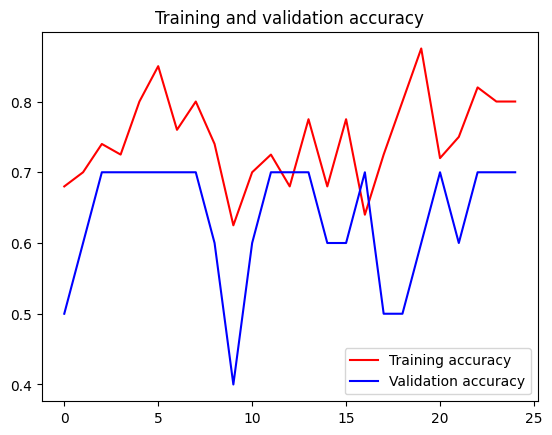

<Figure size 640x480 with 0 Axes>

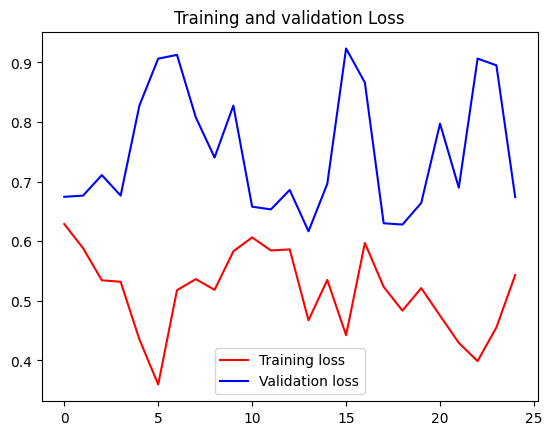

<Figure size 640x480 with 0 Axes>

In [26]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range_acc = range(len(acc))
epochs_range_val_acc = range(len(val_acc))

plt.plot(epochs_range_acc, acc, 'r', label='Training accuracy')
plt.plot(epochs_range_val_acc, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='best')
plt.figure()
plt.show()

epochs_range_loss = range(len(loss))
epochs_range_val_loss = range(len(val_loss))

plt.plot(epochs_range_loss, loss, 'r', label='Training loss')
plt.plot(epochs_range_val_loss, val_loss, 'b', label='Validation loss')
plt.title('Training and validation Loss')
plt.legend(loc='best')
plt.figure()
plt.show()

Saving 552692449.jpg to 552692449.jpg


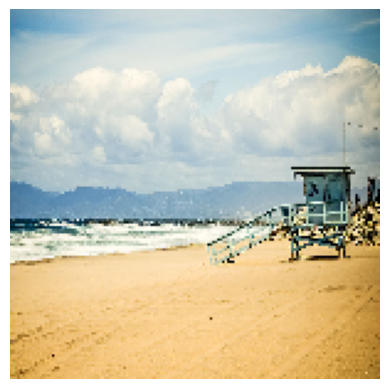

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Prediksi: This is a Beach


In [36]:
import numpy as np
from keras.preprocessing import image
from google.colab import files

uploaded = files.upload()

class_list = ["Beach", "Mountain"]

for fn in uploaded.keys():

    path = fn
    img = image.load_img(path, target_size=(150, 150))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0

    classes = model.predict(x)

    if classes.shape[1] == 2:
        predicted_class = np.argmax(classes, axis=1)[0]
    else:
        predicted_class = int(classes[0][0] > 0.5)

    print(f"Prediksi: This is a {class_list[predicted_class]}")